In [8]:
import sys
import os


import bagpy
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

#%matplotlib notebook
#https://stackoverflow.com/questions/39007571/running-jupyter-with-multiple-python-and-ipython-paths

In [12]:
bag_name = "first_fly.bag"
bag_name1 = "second_fly.bag"


def get_csv(bag_name):
    
    data_dict = {}
    
    # Read bag
    b = bagreader(bag_name)
    
    for topic in b.topics: 
        data = b.message_by_topic(topic)
        data_dict['{}'.format(topic)] = pd.read_csv(data)
        
    return data_dict

In [3]:
exp = get_csv(bag_name); exp1 = get_csv(bag_name1)

[INFO]  Data folder first_fly already exists. Not creating.
[INFO]  Data folder second_fly already exists. Not creating.


# Open bags


Method for opening bags that are located in experiments folder. 


In [13]:
def open_bags(dir_path): 
    bags = {}
    bag_names = []
    for bag_name in os.listdir(dir_path): 
        print("[INFO] Bag name is: {}".format(bag_name))
        if not "bag" in bag_name: 
            bag_name = "{}.bag".format(bag_name)
        # Reindex active bags
        if "active" in bag_name: 
            continue
        bag_names.append(bag_name)
        bags["{}".format(bag_name)] = get_csv("{}/{}".format(dir_path, bag_name))
    return bag_names, bags

bag_names, bags = open_bags("./hpe_paper/experiments")
# How to repair broken bags: http://wiki.ros.org/rosbag/Commandline#reindex
# https://answers.ros.org/question/40116/rosbag-file-cannot-be-made-bagactive/

[INFO] Bag name is: 3_00_2022-04-07-14-08-42.bag
[INFO]  Data folder ./hpe_paper/experiments/3_00_2022-04-07-14-08-42 already exists. Not creating.
[INFO] Bag name is: 8_00_2022-04-11-17-08-54.bag
[INFO]  Data folder ./hpe_paper/experiments/8_00_2022-04-11-17-08-54 already exists. Not creating.
[INFO] Bag name is: 4_00_2022-04-08-16-43-36
[INFO]  Data folder ./hpe_paper/experiments/4_00_2022-04-08-16-43-36 already exists. Not creating.
[INFO] Bag name is: 7_12_2022-04-11-16-58-09
[INFO]  Data folder ./hpe_paper/experiments/7_12_2022-04-11-16-58-09 already exists. Not creating.
[INFO] Bag name is: 6_10_2022-04-11-15-07-33.bag
[INFO]  Data folder ./hpe_paper/experiments/6_10_2022-04-11-15-07-33 already exists. Not creating.
[INFO] Bag name is: 00_00_01_04_rc.bag
[INFO]  Data folder ./hpe_paper/experiments/00_00_01_04_rc already exists. Not creating.
[INFO] Bag name is: 4_00_2022-04-08-16-43-36.bag
[INFO]  Data folder ./hpe_paper/experiments/4_00_2022-04-08-16-43-36 already exists. Not cr

## Utils methods 

* `transform_dict_to_list` 
* `get_flight_duration_from_odom`



In [87]:
def transform_dict_to_list(dict_): 
    
    list_ = []
    list_of_keys = []
    
    for i, key in enumerate(dict_.keys()): 
        list_of_keys.append(eval(key))
    
    
    for key in sorted(list_of_keys): 
        list_.append(dict_[str(key)])
        
    return list_

def get_flight_duration_from_odom(odometry, start_time=None):
    
    if start_time: 
        start_time_ = start_time
    
    time = odometry['Time']
    if start_time: 
        start_time_ = start_time
    else:
        start_time_ = time[0]
    end_time = time[len(time)-1]
    duration = end_time - start_time_

    return duration, start_time, end_time 

## Plot methods 

* `plot_2d_trajectory` --> plot 2d trajectory from odometry
* `plot_3d_trajectory` --> plot 3d trajectory from 
* `plot_3d_2d_trajectory` --> plot 3d and 2d trajectory
* `plot_joy` --> plot joystick


In [100]:
def plot_2d_trajectory(odometry, multiple=False):
    
    x_pos = odometry['pose.pose.position.x']
    y_pos = odometry['pose.pose.position.y']
    
    if not multiple: 
        plt.figure()
    plt.plot(x_pos, y_pos)
    plt.title('2D trajectory')
    plt.xlabel('X position [m]')
    plt.ylabel('Y position [m]')
    plt.legend(loc="best")
    
def plot_3d_trajectory(odometry, multiple=False):
    
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')    
    
    if type(odometry) == list: 
        x_, y_, z_  = [], [], []
        for odom in odometry: 
            x_.append(odom['pose.pose.position.x'])
            y_.append(odom['pose.pose.position.y'])
            z_.append(odom['pose.pose.position.z'])
        
        cnt = 0
        for x, y, z in zip(x_, y_, z_): 
            cnt += 1
            ax.plot(x, y, z, label="flight_{}".format(cnt))
        plt.legend()
            
            
    else: 
        x_pos = odometry['pose.pose.position.x']
        y_pos = odometry['pose.pose.position.y']
        z_pos = odometry['pose.pose.position.z']        
        ax.plot(x_pos, y_pos, z_pos)
    
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_zlabel('z [m]')
    
    plt.show()  
    
def plot_3d_2d_trajectories(odometry, multiple=False):

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))    
    
    if type(odometry) == list: 
        x_, y_, z_  = [], [], []
        for odom in odometry: 
            x_.append(odom['pose.pose.position.x'])
            y_.append(odom['pose.pose.position.y'])
            z_.append(odom['pose.pose.position.z'])
        
        cnt = 0
        for x, y, z in zip(x_, y_, z_): 
            cnt += 1
            if cnt == 1:
                ax[0, 0].remove()
                ax_3d = fig.add_subplot(2, 2, 1, projection="3d")                
            ax_3d.plot(x, y, z, label="{}".format(cnt))            
            ax[0, 1].plot(x, y);           
            ax[1, 0].plot(x, z); 
            ax[1, 1].plot(y, z); 
            
            
        plt.legend()     
            
    else: 
        x = odometry['pose.pose.position.x']
        y = odometry['pose.pose.position.y']
        z = odometry['pose.pose.position.z']
        
        #ax.plot(x_pos, y_pos, z_pos)
        
        ax[0, 0].remove()
        ax_3d = fig.add_subplot(2, 2, 1, projection='3d')        
        # Plot trajectories 
        ax_3d.plot(x, y, z)
        ax[0, 1].plot(x, y); 
        ax[1, 0].plot(x, z); 
        ax[1, 1].plot(y, z); 
    
    # [0, 0]
    ax_3d.set_xlabel('x[m]'); ax_3d.set_ylabel('y[m]'); ax_3d.set_zlabel('z[m]')
    # [0, 1]
    ax[0, 1].grid(); ax[0, 1].set_xlabel('x[m]'); ax[0, 1].set_ylabel('y[m]')
    # [1, 0]
    ax[1, 0].grid(); ax[1, 0].set_xlabel('x[m]'); ax[1, 0].set_ylabel('z[m]')
    # [1, 1]
    ax[1, 1].grid(); ax[1, 1].set_xlabel('y[m]'); ax[1, 1].set_ylabel('z[m]')
    
    plt.title("UAV trajectories")
    plt.show()      
    
def plot_joy(joy, multiple=False):
    """
    roll:   2
    pitch:  3
    yaw:    0 
    height: 1
    """
    joy_axes0 = joy['axes_0']
    joy_axes1 = joy['axes_1']
    joy_axes2 = joy['axes_2']
    joy_axes3 = joy['axes_3']
    time = joy['Time']
    
    if not multiple: 
        plt.figure()
    
    plt.title("Joystick output")
    plt.plot(time, joy_axes0, label="yaw");
    plt.plot(time, joy_axes1, label="z");
    plt.plot(time, joy_axes2, label="roll");
    plt.plot(time, joy_axes3, label="pitch");
    
    plt.legend(loc="best")
    
def plot_joy_comparison(joy1, joy2):
    
    time1 = joy1['Time']; time2 = joy2['Time']
    joy11 = joy1['axes_0']; joy21 = joy2['axes_0']
    joy12 = joy1['axes_1']; joy22 = joy2['axes_1']
    joy13 = joy1['axes_2']; joy23 = joy2['axes_2']
    joy14 = joy1['axes_3']; joy24 = joy2['axes_3']
    
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    
    ax[0].plot(time1, joy11, label="yaw");  ax[0].plot(time1, joy12, label="z"); 
    ax[0].plot(time1, joy13, label="roll"); ax[0].plot(time1, joy14, label="pitch"); 
    ax[1].plot(time2, joy21, label="yaw"); ax[1].plot(time2, joy22, label="z"); 
    ax[1].plot(time2, joy23, label="roll"); ax[1].plot(time2, joy24, label="pitch"); 
    ax[0].grid(); ax[0].set_xlabel('t [s]'); ax[0].set_title('HPE joystick'); ax[0].legend(loc="best")
    ax[1].grid(); ax[1].set_xlabel('t [s]'); ax[1].set_title('RC joystick'); ax[1].legend(loc="best")
    
def get_joy_params(joy): 
    
    time = joy['Time']
    start_time = time[0]
    end_time = time[len(time)-1]
    
    duration = end_time - start_time
    
    joy_axes0 = joy['axes_0']
    joy_axes1 = joy['axes_1']
    joy_axes2 = joy['axes_2']
    joy_axes3 = joy['axes_3']
    
    sum_axes0 = sum(joy_axes0) 
    sum_axes1 = sum(joy_axes1)
    sum_axes2 = sum(joy_axes2)
    sum_axes3 = sum(joy_axes3)
    
    sum_axes = sum([sum_axes0, sum_axes1, sum_axes2, sum_axes3])
    
    return sum_axes, sum_axes0, sum_axes1, sum_axes2, sum_axes3, duration            
    

In [101]:
# Bags are opened
def extract_data(bags, return_all = False): 
    
    data = {}
    
    hpe_odometries, hpe_joys, hpe_durations = {}, {}, {}
    rc_odometries, rc_joys, rc_durations = {}, {}, {}
    user_ids = []
    
    for bag_name in bags.keys(): 
        
        list_of_tokens = bag_name.split("_")
        user_id = list_of_tokens[0]
        user_ids.append(eval(list_of_tokens[0]))
        
        
        if eval(list_of_tokens[1][0]) == 0: 
            task = "hpe"
        
        if eval(list_of_tokens[1][0]) == 1:
            task = "rc"                
            
        try:
            start_time = bags[bag_name]['/start_time']['data.secs'][0]
        except Exception as e: 
            start_time = None
            print(str(e))
        
        odom_ = bags[bag_name]['/bebop/odometry']
        joy_ = bags[bag_name]['/joy']
        duration_ = get_flight_duration_from_odom(odom_, start_time=start_time)
        
        data['{}_{}_odometry'.format(user_id, task)] = odom_
        data['{}_{}_joy'.format(user_id, task)] = joy_
        data['{}_{}_flight_duration'.format(user_id, task)] = duration_
        
        if task == "hpe": 
            hpe_odometries['{}'.format(eval(user_id))] = odom_
            hpe_joys['{}'.format(eval(user_id))] = joy_ 
            hpe_durations['{}'.format(eval(user_id))] = duration_
        
        if task == "rc": 
            rc_odometries['{}'.format(eval(user_id))] = odom_
            rc_joys['{}'.format(eval(user_id))] = joy_
            rc_durations['{}'.format(eval(user_id))] = duration_
            
    if return_all: 
        return hpe_odometries, hpe_joys, hpe_durations, rc_odometries, rc_joys, rc_durations, user_ids
    
    else: 
        return data

hpe_odometries, hpe_joys, hpe_durations, rc_odometries, rc_joys, rc_durations, uids = extract_data(bags, return_all = True)


'/start_time'


[3, 8, 4, 7, 6, 0, 0, 10, 6, 4, 2, 10, 9, 8, 9, 7, 2, 3]


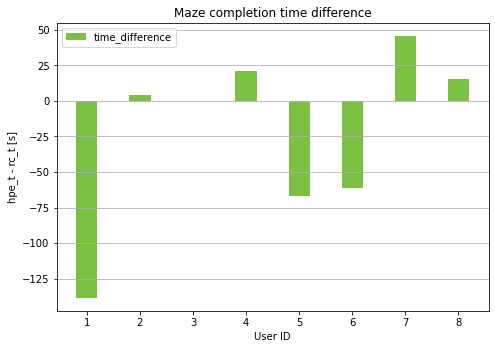

In [102]:
print(uids)
h_odom_ = transform_dict_to_list(hpe_odometries)
h_joy_ = transform_dict_to_list(hpe_joys)
h_durations_ = transform_dict_to_list(hpe_durations)
h_durations_sec = [i[0] for i in h_durations_]
r_odom_ = transform_dict_to_list(rc_odometries)
r_joy_ = transform_dict_to_list(rc_joys)
r_durations_ = transform_dict_to_list(rc_durations)
r_durations_sec = [i[0] for i in r_durations_]

# Get fastest participants based on (end_recording_time - start_time)
fastest_rc_participant = r_durations_sec.index(min(r_durations_sec))
fastest_hpe_participant = h_durations_sec.index(min(h_durations_sec))

# Get time difference 
time_difference = [round(i - j, 2) for i, j in zip(h_durations_sec, r_durations_sec)]

# Plot bar graph of time difference
origin_dir = "hpe_paper"
X = np.arange(len(time_difference)) + 1
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X , time_difference, color="#7bc043", width=0.4)
ax.grid(axis="y")
ax.set_title("Maze completion time difference")
ax.set_xlabel("User ID")
ax.set_ylabel("hpe_t - rc_t [s]")
ax.legend(labels=["time_difference"])
fig.savefig("./{}/time_difference.svg".format(origin_dir))

<Figure size 432x288 with 0 Axes>

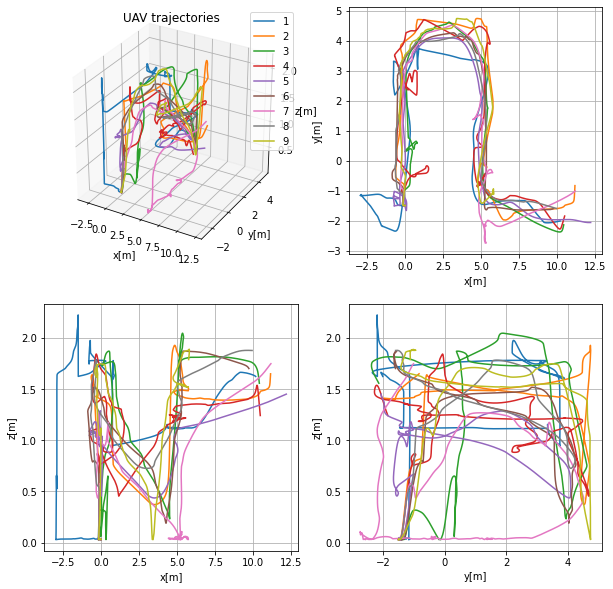

<Figure size 432x288 with 0 Axes>

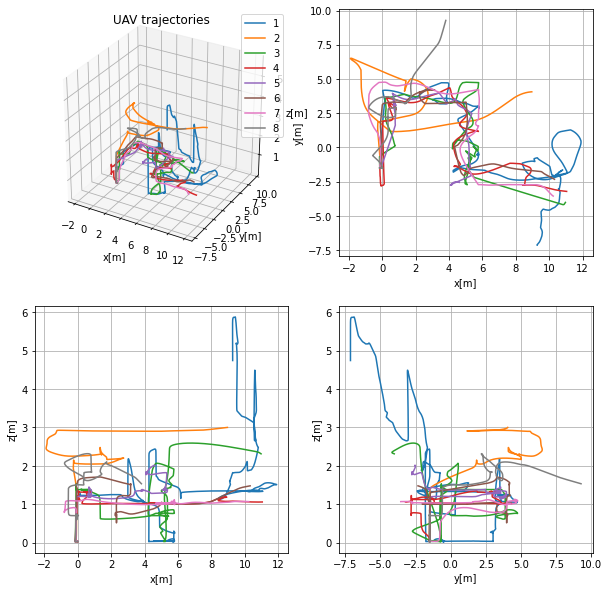

In [103]:
plt.figure()
plot_3d_2d_trajectories(h_odom_)

plt.figure()
plot_3d_2d_trajectories(r_odom_)

In [104]:
def get_joy_params(joy): 
    
    time = joy['Time']
    start_time = time[0]
    end_time = time[len(time)-1]
    
    duration = end_time - start_time
    
    joy_axes0 = joy['axes_0']
    joy_axes1 = joy['axes_1']
    joy_axes2 = joy['axes_2']
    joy_axes3 = joy['axes_3']
    
    sum_axes0 = sum(joy_axes0) 
    sum_axes1 = sum(joy_axes1)
    sum_axes2 = sum(joy_axes2)
    sum_axes3 = sum(joy_axes3)
    
    sum_axes = sum([sum_axes0, sum_axes1, sum_axes2, sum_axes3])
    
    return sum_axes, sum_axes0, sum_axes1, sum_axes2, sum_axes3, duration           

odometry = exp['/bebop/odometry']
joy = exp['/joy']
#joy = pd.read_csv(csv_files[1])

odometry1 = exp1['/bebop/odometry']
joy1 = exp['/joy']
#joy1 = pd.read_csv(csv_files[1])

# Compare results 
odometry00 = bags["00_01_01_04_hpe.bag"]['/bebop/odometry']
odometry01 = bags["00_00_01_04_rc.bag"]['/bebop/odometry']
odometry02 = bags["2_00_2022-04-06-13-02-08.bag"]['/bebop/odometry']
odometry03 = bags["3_00_2022-04-07-14-08-42.bag"]['/bebop/odometry']
joy00 = bags["00_01_01_04_hpe.bag"]['/joy']
joy01 = bags["00_00_01_04_rc.bag"]['/joy']
joy02 = bags["2_00_2022-04-06-13-02-08.bag"]['/joy']
joy03 = bags["3_00_2022-04-07-14-08-42.bag"]['/joy']
start_time00 = odometry00['Time']
start_time01 = bags["00_00_01_04_rc.bag"]['/start_time']
start_time02 = bags["2_00_2022-04-06-13-02-08.bag"]['/start_time']

duration00, start00, end00 = get_flight_duration_from_odom(odometry00)
duration01, start01, end01 = get_flight_duration_from_odom(odometry01)
duration02, start02, end02 = get_flight_duration_from_odom(odometry02)
duration03, start03, end03 = get_flight_duration_from_odom(odometry03)

In [65]:
x_pos = odometry['pose.pose.position.x']
y_pos = odometry['pose.pose.position.y']
z_pos = odometry['pose.pose.position.z']

x1_pos = odometry1['pose.pose.position.x']
y1_pos = odometry1['pose.pose.position.y']
z1_pos = odometry1['pose.pose.position.z']

joy_axes0 = joy['axes_0']
joy_axes1 = joy['axes_1']
joy_axes2 = joy['axes_2']
joy_axes3 = joy['axes_3']


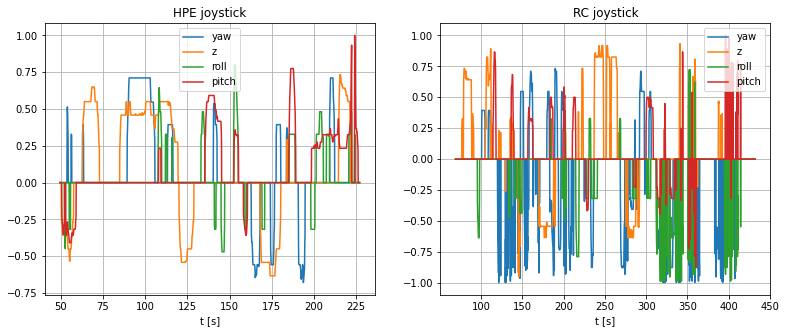

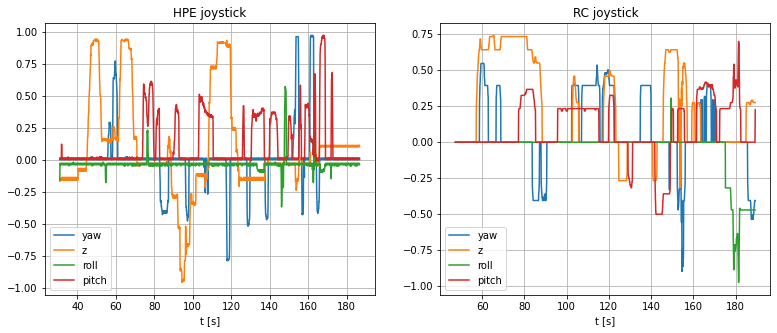

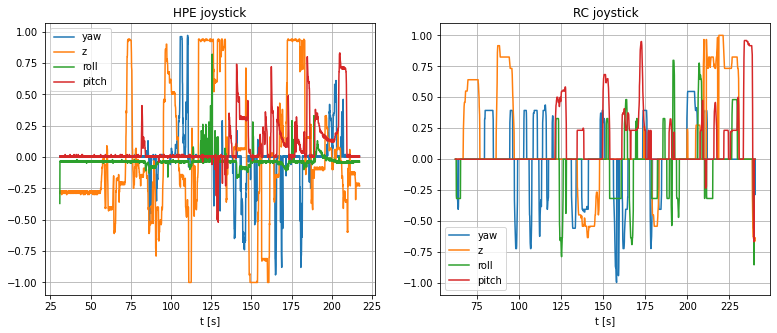

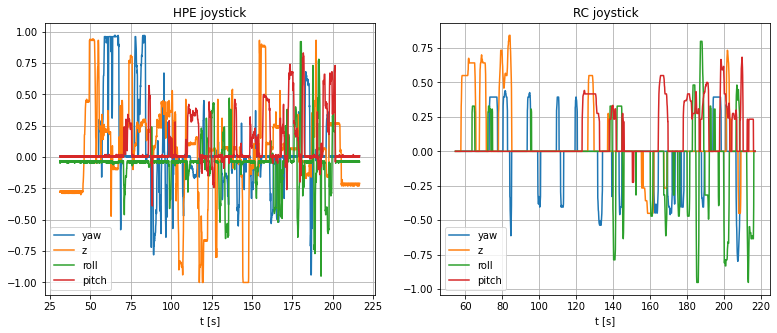

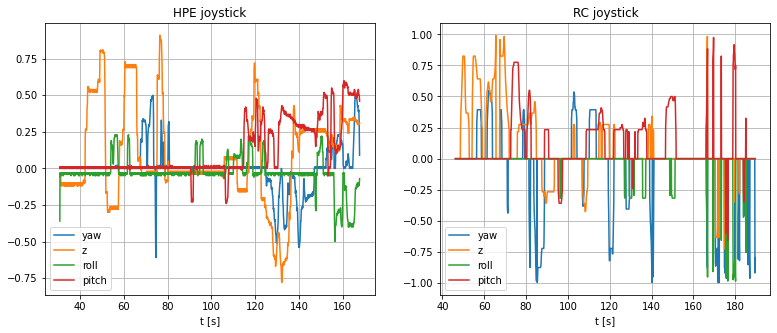

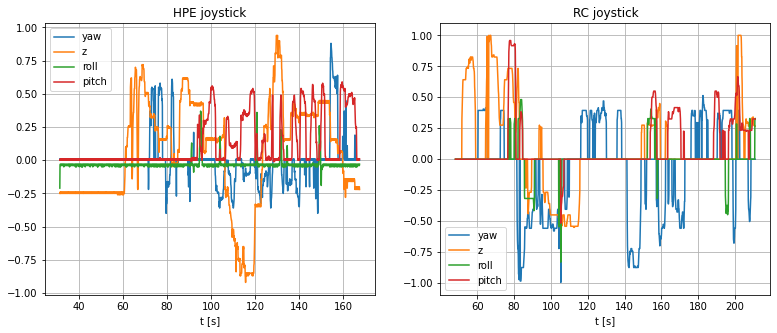

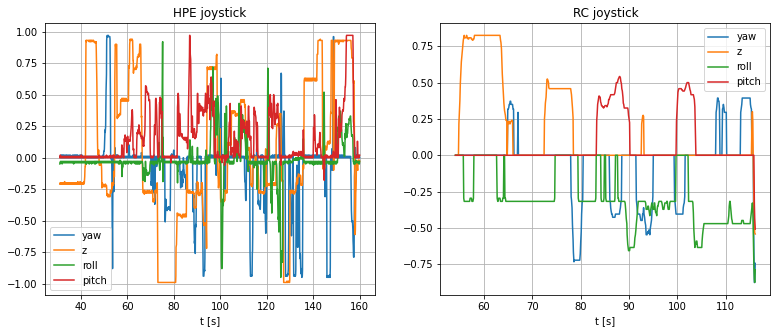

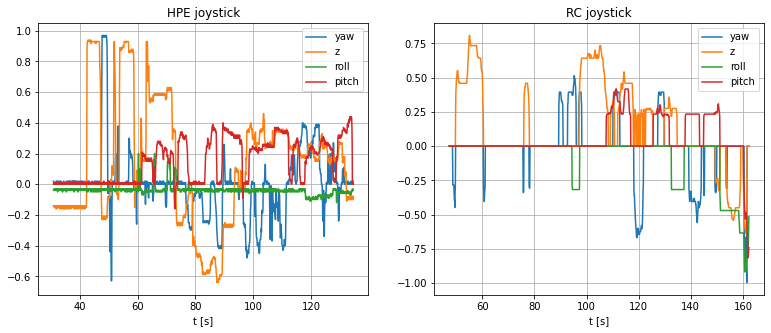

In [71]:
plot_joy_comparison(h_joy_[0], r_joy_[0])
plot_joy_comparison(h_joy_[1], r_joy_[1])
plot_joy_comparison(h_joy_[2], r_joy_[2])
plot_joy_comparison(h_joy_[3], r_joy_[3])
plot_joy_comparison(h_joy_[4], r_joy_[4])
plot_joy_comparison(h_joy_[5], r_joy_[5])
plot_joy_comparison(h_joy_[6], r_joy_[6])
plot_joy_comparison(h_joy_[7], r_joy_[7])

<Figure size 432x288 with 0 Axes>

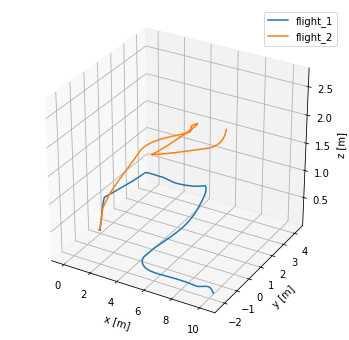

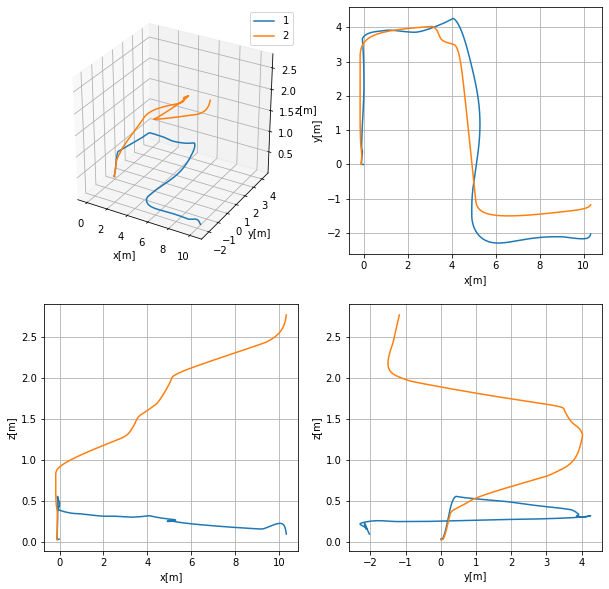

In [92]:
# Could basically plot in different colors depending on linear velocity
#plt.figure()
#plot_2d_trajectory(odometry, multiple=True)
#plot_2d_trajectory(odometry1, multiple=True)

# TODO: Plot in different colors depending on linear velocity? 
# TODO: Add labyrinth to plots
# TODO: Add different plots depending on maze passage time 
plt.figure()
plot_3d_trajectory([odometry, odometry1], multiple=True)
plot_3d_2d_trajectories([odometry, odometry1])

## Plot experiment comparisons 


<Figure size 432x288 with 0 Axes>

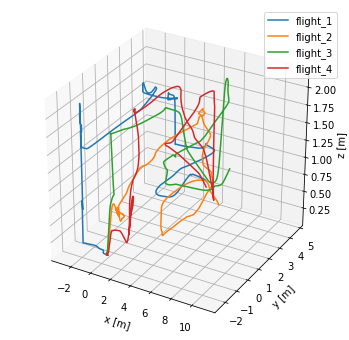

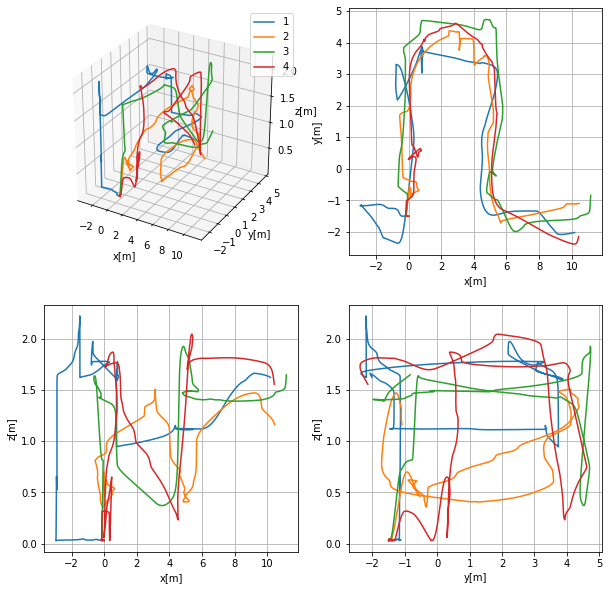

RC sum: 415.34791649878025
HPE sum: 181.71999878808856
RC time: 177.411
HPE time: 151.389


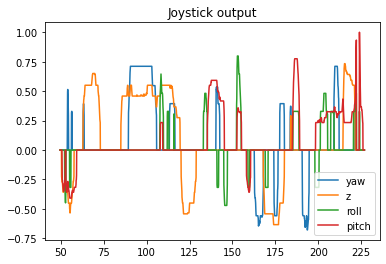

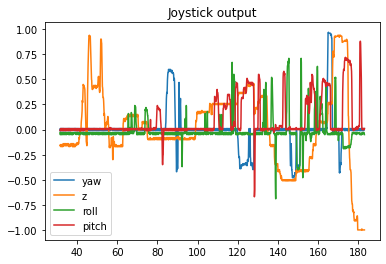

In [93]:
plt.figure()
plot_3d_trajectory([odometry00, odometry01, odometry02, odometry03], multiple=True)
plot_3d_2d_trajectories([odometry00, odometry01, odometry02, odometry03])

plot_joy(joy00); 
plot_joy(joy01);

# RC Joy
rc_sum_, rc_sum0, rc_sum1, rc_sum2, rc_sum3, rc_t = get_joy_params(joy00)
hpe_sum_ , hpe_sum0, hpe_sum1, hpe_sum2, hpe_sum3, hpe_t = get_joy_params(joy01)

print("RC sum: {}".format(rc_sum_))
print("HPE sum: {}".format(hpe_sum_))
print("RC time: {}".format(rc_t))
print("HPE time: {}".format(hpe_t))

## Plot 3D trajectory 

# Bar plot for evaluating human ratings using NASA TLX


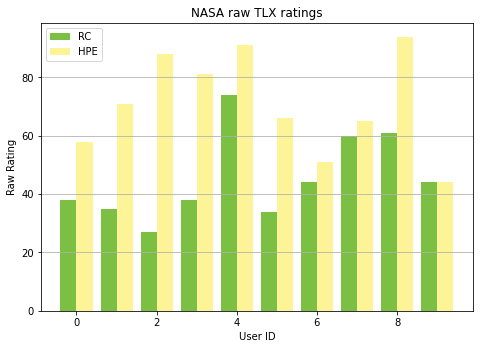

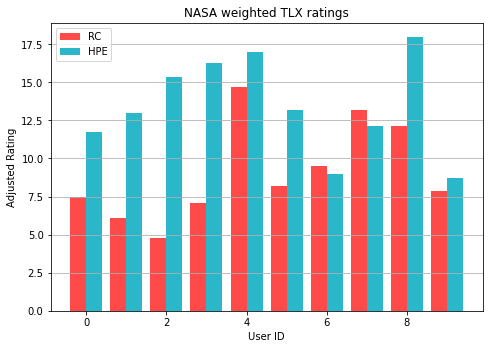

In [82]:
origin_dir = "hpe_paper"

# Raw rating 
rc_raw_ratings = [38, 35, 27, 38, 74, 34, 44, 60, 61, 44] 
hpe_raw_ratings = [58, 71, 88, 81, 91, 66, 51, 65, 94, 44]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, rc_raw_ratings, color="#7bc043", width=0.4)
ax.bar(X + 0.2, hpe_raw_ratings, color="#fdf498", width=0.4)
ax.grid(axis="y")
ax.set_title("NASA raw TLX ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/nasa_raw_tlx_ratings.svg".format(origin_dir))

# Weighted rating 
X = np.arange(10)
rc_w_ratings  = [7.47, 6.07, 4.80, 7.07, 14.67,  8.20,  9.53,  13.20, 12.13, 7.87]
hpe_w_ratings = [11.73, 13.00, 15.33, 16.27, 17.00, 13.20, 9.00, 12.13, 18.00, 8.73]
fig = plt.figure()
ax = fig.add_axes([0,0, 1, 1])
ax.bar(X - 0.2, rc_w_ratings, color = "#fe4a49", width = 0.4)
ax.bar(X + 0.2, hpe_w_ratings, color = '#2ab7ca', width = 0.4)
ax.grid(axis="y")
ax.set_title("NASA weighted TLX ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Adjusted Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/nasa_weighted_tlx_ratings.svg".format(origin_dir))

# Nice colors for plots can be found here: https://digitalsynopsis.com/design/beautiful-color-palettes-combinations-schemes/


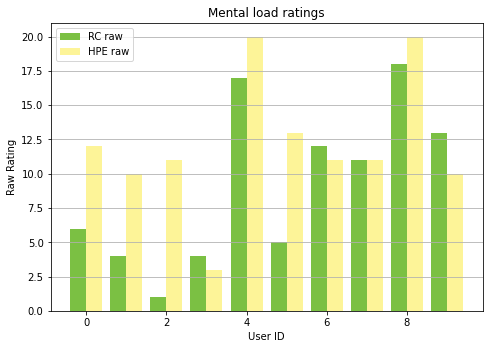

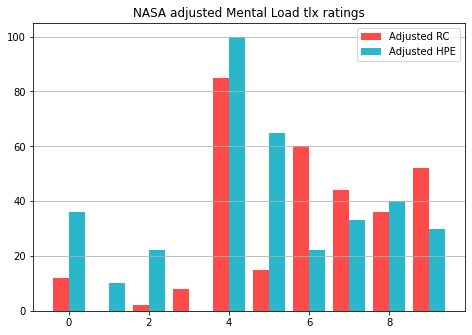

In [95]:
# Mental demand 
X = np.arange(10)
md_raw_rc  = [6, 4, 1, 4, 17, 5, 12, 11, 18, 13];
md_raw_hpe = [12, 10, 11, 3, 20, 13, 11, 11, 20, 10];
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, md_raw_rc, color="#7bc043", width=0.4)
ax.bar(X + 0.2, md_raw_hpe, color="#fdf498", width=0.4)
ax.grid(axis="y")
ax.set_title("Mental load ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC raw", "HPE raw", "RC adjusted", "HPE adjusted"])
fig.savefig("./{}/raw_mental_demand_tlx_ratings.svg".format(origin_dir))

# Adjusted mental demand
md_w_rc  =  [12, 0, 2, 8, 85, 15, 60, 44, 36, 52]; 
md_w_hpe =  [36, 10, 22, 0, 100, 65, 22, 33, 40, 30];
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.grid(axis="y")
ax.bar(X - 0.2, md_w_rc, color="#fe4a49", width=0.4)
ax.bar(X + 0.2, md_w_hpe, color="#2ab7ca", width=0.4)
ax.set_title("NASA adjusted Mental Load tlx ratings")
ax.legend(labels=["Adjusted RC", "Adjusted HPE"])
fig.savefig("./{}/adjusted_mental_demand_tlx_ratings.svg".format(origin_dir))



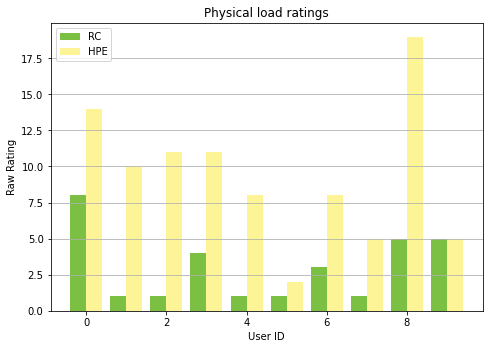

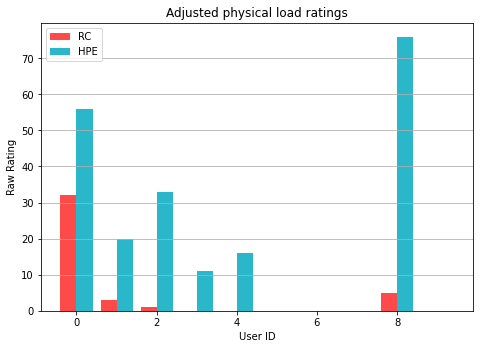

In [96]:
# Physical demand 
X = np.arange(10)
pd_raw_rc  = [8, 1, 1, 4, 1, 1, 3, 1, 5, 5];
pd_raw_hpe = [14, 10, 11, 11, 8, 2, 8, 5, 19, 5];
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, pd_raw_rc, color="#7bc043", width=0.4)
ax.bar(X + 0.2, pd_raw_hpe, color="#fdf498", width=0.4)
ax.grid(axis="y")
ax.set_title("Physical load ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/raw_physical_demand_tlx_ratings.svg".format(origin_dir))

# Adjusted physical demand
pd_w_rc  = [32, 3, 1, 0, 0, 0, 0, 0, 5, 0]
pd_w_hpe = [56, 20, 33, 11, 16 ,0, 0, 0, 76, 0]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, pd_w_rc, color="#fe4a49", width=0.4)
ax.bar(X + 0.2, pd_w_hpe, color="#2ab7ca", width=0.4)
ax.grid(axis="y")
ax.set_title("Adjusted physical load ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/adjusted_physical_demand_tlx_ratings.svg".format(origin_dir))




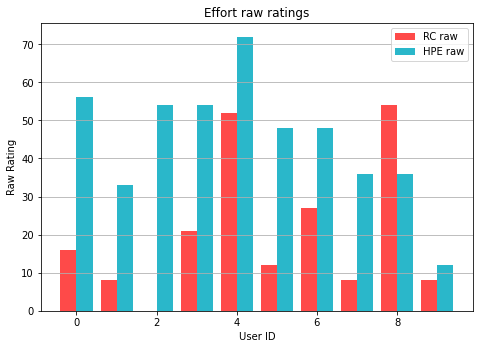

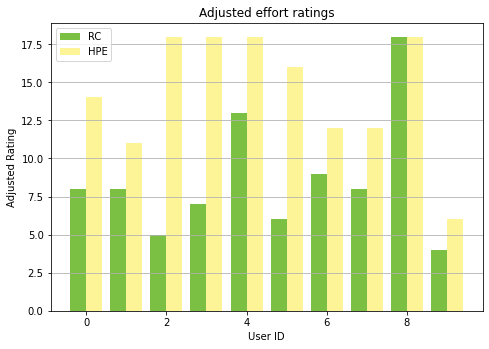

In [98]:
# Adjusted physical effort
X = np.arange(10)
effort_raw_rc  = [16, 8, 0, 21, 52, 12, 27, 8, 54, 8]
effort_raw_hpe = [56, 33, 54, 54, 72, 48, 48, 36, 36, 12]
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, effort_raw_rc, color="#fe4a49", width=0.4)
ax.bar(X + 0.2, effort_raw_hpe, color="#2ab7ca", width=0.4)
ax.grid(axis="y")
ax.set_title("Effort raw ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Raw Rating")
ax.legend(labels=["RC raw", "HPE raw"])
fig.savefig("./{}/effort_raw_demand_tlx_ratings.svg".format(origin_dir))

# Raw effort
effort_w_rc  = [8, 8, 5, 7, 13, 6, 9, 8, 18, 4]
effort_w_hpe = [14, 11, 18, 18, 18, 16, 12, 12, 18, 6] 
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(X - 0.2, effort_w_rc, color="#7bc043", width=0.4)
ax.bar(X + 0.2, effort_w_hpe, color="#fdf498", width=0.4)
ax.grid(axis="y")
ax.set_title("Adjusted effort ratings")
ax.set_xlabel("User ID")
ax.set_ylabel("Adjusted Rating")
ax.legend(labels=["RC", "HPE"])
fig.savefig("./{}/effort_adjusted_demand_tlx_ratings.svg".format(origin_dir))

# Evaluating zone control for rectangles 


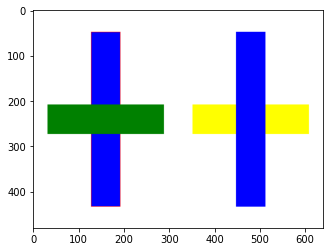

In [11]:
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import numpy as np


def define_zones(img_width, img_height, edge_offset, rect_width):
        
        # img center
        cx, cy = img_width/2, img_height/2
        # 1st zone
        cx1, cy1 = cx/2, cy/2
        # 2nd zone
        cx2, cy2 = cx + cx1, cy + cy1
        
        # Define offsets from edge
        if edge_offset < 1: 
            height_edge = edge_offset * img_height
            width_edge = edge_offset/2 * img_width

        # Zone definition 
        if rect_width < 1: 
            r_width = rect_width * img_width

        height_rect = ((cx1 - r_width, height_edge), (cx1 + r_width, img_height - height_edge))
        yaw_rect = ((width_edge, cy - r_width), (cx - width_edge, cy + r_width))
        pitch_rect = ((cx2 - r_width, height_edge), (cx2 + r_width, img_height - height_edge))
        roll_rect = ((cx + width_edge, cy-r_width), (img_width - width_edge), (cy + r_width))
        
        return height_rect, yaw_rect, pitch_rect, roll_rect

img_height = 480
img_width = 640
img = Image.new('RGB', (img_width, img_height), color = 'white')

height_rect, yaw_rect, pitch_rect, roll_rect = define_zones(img_width, img_height, 0.1, 0.05)

img1 = ImageDraw.Draw(img)  
img1.rectangle(height_rect, fill ="blue", outline ="red")
img1.rectangle(yaw_rect, fill="green")
img1.rectangle(roll_rect, fill="yellow")
img1.rectangle(pitch_rect, fill="blue")
imshow(np.asarray(img))